### SNN class(Spiking Neural Network)

In [8]:
%run models.ipynb
#n--> network
class SNN:
    def __init__(self, n_dim, lif_n_parametr, time_course, tau_tag, tau_dopamine, reward, j=8):
        self.network_dim = n_dim
        self.lif_n_parametr = lif_n_parametr
        self.c = self.make_fullconnections_c
        self.n_neurons = []
        self.c_list = []
        self.j = j
        self.tau_dopamine = tau_dopamine
        self.tau_tag = tau_tag
        self.tags = []
        self.reward = reward
        self.c_history = []
        self.time_course = time_course
        self.make_nk_neurons()
        self.c()
        self.d = 0

    def Rand_current(self):
       def __init__(self, i=1, step=100):
            self.last_i = 0
            self.up_high = True
            self.i = i
            self.step = step

       def get(self, it):
            if it % 20 == 0:
                self.up_high = not self.up_high
            tmp = random.random()
            if self.up_high:
                tmp = self.last_i + tmp * (self.i / 2)
            else:
                tmp = self.last_i - tmp * (self.i / 2)
            if tmp > self.i * 2 or tmp < 0:
                tmp = random.random() * self.i
            self.last_i = tmp
            return tmp



    def make_fullconnections_c(self):
        for i in range(1, len(self.network_dim)):
            self.c_list.append(np.ones((self.network_dim[i - 1], self.network_dim[i])) *
                               self.j + np.random.rand())
            self.c_history.append(deepcopy(self.c_list[-1].ravel()))
            self.tags.append(np.zeros((self.network_dim[i - 1], self.network_dim[i])))

    def make_nk_neurons(self):
        for i in range(len(self.network_dim)):
            neuron_list = []
            for j in range(self.network_dim[i]):
                if not self.lif_n_parametr['random']:
                    neuron_list.append(
                        LIF(
                            self.lif_n_parametr['R'],
                            self.lif_n_parametr['tau'],
                            self.lif_n_parametr['u_rest'],
                            self.lif_n_parametr['threshold'],
                            self.lif_n_parametr['u_spike'],
                            self.lif_n_parametr['u_reset']
                        )
                    )
                else:
                    neuron_list.append(
                        LIF(
                            self.lif_n_parametr['R'] + np.random.rand() *
                            self.lif_n_parametr['rand_change'],
                            self.lif_n_parametr['tau'] + np.random.rand() *
                            self.lif_n_parametr['rand_change'],
                            self.lif_n_parametr['u_rest'] + np.random.rand() *
                            self.lif_n_parametr['rand_change'],
                            self.lif_n_parametr['threshold'] + np.random.rand() *
                            self.lif_n_parametr['rand_change'],
                            self.lif_n_parametr['u_spike'] + np.random.rand() *
                            self.lif_n_parametr['rand_change'],
                            self.lif_n_parametr['u_reset'] + np.random.rand() *
                            self.lif_n_parametr['rand_change']
                        )
                    )
            self.n_neurons.append(deepcopy(neuron_list))

    def compatible(self, x, y, step,
                   epoch_time, step_minus,
                   dt_plus, a_minus, a_plus,
                   time_course_thre, iter,
                   learn_time):
        template = 0
        lt = learn_time
        for iter in range(iter):
            idx = np.random.randint(low=0, high=x.shape[0])
            epoch = 0
            while epoch < epoch_time:
                inputs = x[idx]
                for layer in range(len(self.n_neurons)):
                    for i, neuron in enumerate(self.n_neurons[layer]):
                        neuron.one_step(inputs[i], template, step)
                    if layer != len(self.n_neurons) - 1:
                        activities = self.cal_act(layer, template + step, step, time_course_thre)
                        inputs = activities @ self.c_list[layer]
                flag = False
                if template > lt:
                    flag = True
                    lt += learn_time
                self.get_information(y, idx, template + step, step, step_minus, dt_plus, a_minus, a_plus, learn_time, flag)
                if flag:
                    flag = False
                epoch += step
                template += step

    def get_information(self, y, index, time, step, step_minus, dt_plus, a_minus, a_plus, learn_time, flag):
        for shell in range(len(self.c_list)):
            for i in range(len(self.n_neurons[shell])):
                for j in range(len(self.n_neurons[shell + 1])):
                    pre_neuron = self.n_neurons[shell][i]
                    post_neuron = self.n_neurons[shell][j]
                    stdp = 0
                    if len(pre_neuron.spikes) != 0 and len(post_neuron.spikes) != 0 and \
                            post_neuron.spikes[len(post_neuron.spikes) - 1] == time:
                        if post_neuron.spikes[len(post_neuron.spikes) - 1] > pre_neuron.spikes[
                            len(pre_neuron.spikes) - 1]:
                            step = abs(post_neuron.spikes[len(post_neuron.spikes) - 1] -
                                       pre_neuron.spikes[len(pre_neuron.spikes) - 1])
                            stdp += a_plus * math.exp(-(step / dt_plus))

                    if len(pre_neuron.spikes) == 0 or len(post_neuron.spikes) == 0 or pre_neuron.spikes[
                        len(pre_neuron.spikes) - 1] != time:
                        pass
                    else:
                        if post_neuron.spikes[len(post_neuron.spikes) - 1] < pre_neuron.spikes[
                            len(pre_neuron.spikes) - 1]:
                            step = abs(post_neuron.spikes[len(post_neuron.spikes) - 1] -
                                       pre_neuron.spikes[len(pre_neuron.spikes) - 1])
                            stdp += a_minus * math.exp(-(step / step_minus))

                    self.tags[shell][i, j] += step * ((-self.tags[shell][i, j] / self.tau_tag) + stdp)
                    self.c_list[shell][i, j] += step * (self.tags[shell][i, j] * self.d)
                    if self.c_list[shell][i, j] >= 0:
                        continue
                    self.c_list[shell][i, j] = 0

        reward = 0
        if not flag:
            pass
        else:
            actions = np.zeros_like(self.n_neurons[-1])
            for i, neuron in enumerate(self.n_neurons[-1]):
                quantity = 0
                for spike in reversed(neuron.spikes):
                    if spike <= learn_time:
                        continue
                    quantity += 1
                actions[i] = quantity
            if np.argmax(actions) == int(y[index]):
                big_int = heapq.nlargest(2, list(actions))
                if big_int[0] != 0 and (big_int[0] - big_int[1]) / big_int[0] > 0.1:
                    reward += self.reward
                else:
                    reward -= self.reward
            else:
                reward -= self.reward
        self.d += learn_time * ((-self.d / self.tau_dopamine) + reward)
        for i in range(len(self.c_history)):
            self.c_history[i] = np.vstack((self.c_history[i], self.c_list[i].ravel()))

    def cal_act(self, layer, time, dt, time_course_threshold):
        activity_list = np.zeros(self.network_dim[layer])
        for idx in range(self.network_dim[layer]):
            activity_list[idx] = self.cal_act_one(layer, idx, time, dt, time_course_threshold)
        return activity_list

    def cal_act_one(self, layer, index, time, dt, time_course_threshold):
        neuron = self.n_neurons[layer][index]
        S = 0
        activity = 0
        while time_course_threshold < self.time_course(S):
            if (time - S) in neuron.spikes:
                activity += self.time_course(S)
            S += dt
        return activity

    def forestall(self, x, t_interval, dt, t_course_thre):
        out = np.zeros((len(x)))
        for i in range(len(x)):
            self.reset()
            time = 0
            while time < t_interval:
                inputs = x[i]
                for layer in range(len(self.n_neurons)):
                    for k, neuron in enumerate(self.n_neurons[layer]):
                        neuron.one_step(inputs[k], time, dt)
                    if layer != len(self.n_neurons) - 1:
                        activities = self.cal_act(layer, time + dt, dt, t_course_thre)
                        inputs = activities @ self.c_list[layer]
                time += dt
            end_layer = self.n_neurons[-1]
            end_layer_result = np.zeros((len(end_layer)))
            for j in range(len(end_layer_result)):
                end_layer_result[j] = len(end_layer[j].spikes)
            out[i] = np.argmax(end_layer_result)
        return out

    def reset(self):
        for i in range(len(self.n_neurons)):
            for neuron in self.n_neurons[i]:
                neuron.dell()
        pass


def t_course(time, sigma=25, m=0):
    return 500 * (1 / (sigma * math.sqrt(2 * math.pi))) * math.exp(-((time - m) / sigma) ** 2)


### Plotting

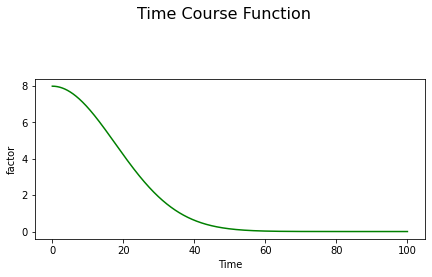

In [9]:
ts = np.arange(0, 100, 0.01)
y_lists = np.zeros_like(ts)
for i, t in enumerate(ts):
    y_lists[i] = t_course(t)

figure = plt.figure(figsize=(7, 10))
figure.suptitle('Time Course Function', fontsize=16)
r = figure.add_subplot(311)
r.plot(ts, y_lists, color='green')
r.set_ylabel("factor")
r.set_xlabel("Time")
plt.show()